This dataset contains 1,015,342 questionnaire answers collected online by Open Psychometrics. Learn more at https://www.kaggle.com/tunguz/big-five-personality-test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_na = pd.read_csv('data-final.csv', delimiter = '\t')

In [3]:
data_na.shape

(1015341, 110)

In [4]:
data_na.columns

Index(['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9',
       'EXT10',
       ...
       'dateload', 'screenw', 'screenh', 'introelapse', 'testelapse',
       'endelapse', 'IPC', 'country', 'lat_appx_lots_of_err',
       'long_appx_lots_of_err'],
      dtype='object', length=110)

First 50 features are answers to questions, next 50 are time spend on that question (in milliseconds), and rest is defined as follows:

- dateload    The timestamp when the survey was started.
- screenw     The width the of user's screen in pixels
- screenh     The height of the user's screen in pixels
- introelapse The time in seconds spent on the landing / intro page
- testelapse  The time in seconds spent on the page with the survey questions
- endelapse   The time in seconds spent on the finalization page (where the user was asked to indicate if they has answered  accurately and their answers could be stored and used for research. Again: this dataset only includes users who answered "Yes" to this question, users were free to answer no and could still view their results either way)
- IPC         The number of records from the user's IP address in the dataset. For max cleanliness, only use records where this value is 1. High values can be because of shared networks (e.g. entire universities) or multiple submissions
- country     The country, determined by technical information (NOT ASKED AS A QUESTION)
- lat_appx_lots_of_err    approximate latitude of user. determined by technical information, THIS IS NOT VERY ACCURATE. Read the article "How an internet mapping glitch turned a random Kansas farm into a digital hell" https://splinternews.com/how-an-internet-mapping-glitch-turned-a-random-kansas-f-1793856052 to learn about the perils of relying on this information
- long_appx_lots_of_err   approximate longitude of user

## Cleaning

In [5]:
data_na.isnull().astype(int).sum()

EXT1                     1783
EXT2                     1783
EXT3                     1783
EXT4                     1783
EXT5                     1783
                         ... 
endelapse                   0
IPC                         0
country                    77
lat_appx_lots_of_err        0
long_appx_lots_of_err       0
Length: 110, dtype: int64

In [6]:
data=data_na.dropna()

In [7]:
data=data[data.IPC == 1]
data=data.drop('IPC',axis=1)

In [8]:
data=data.drop(['lat_appx_lots_of_err','long_appx_lots_of_err'],axis=1)

## Feature engineering

In [9]:
data['year'] = data['dateload'].apply(lambda x:int(x[0: 4]))
data['month'] = data['dateload'].apply(lambda x:int(x[5: 7]))
data['date'] = data['dateload'].apply(lambda x:int(x[8: 10]))
data['hour'] = data['dateload'].apply(lambda x:int(x[11: 13]))
data=data.drop('dateload',axis=1)

In [10]:
data['screenw'].value_counts()

1366.0    123200
1920.0     84013
1280.0     82142
360.0      74994
375.0      65317
           ...  
998.0          1
2780.0         1
6064.0         1
1897.0         1
2169.0         1
Name: screenw, Length: 1128, dtype: int64

In [11]:
data['screenh'].value_counts()

768.0     132505
1080.0     79428
900.0      78740
640.0      68651
667.0      60521
           ...  
348.0          1
256.0          1
467.0          1
681.0          1
1545.0         1
Name: screenh, Length: 1006, dtype: int64

Multiplying these two features can serve as one multiclass feature (Lots of samples have screens with width of 1366 and height of 768, they should be in same class 1366*768)

In [12]:
data['screen_res_class'] = data['screenh'] * data['screenw']
data=data.drop(['screenw','screenh'], axis=1)

In [13]:
data.shape

(694886, 109)

At each trait, half of the questions are reserved for one side of the trait's spectrum; and other half for the other side. We can leverage that and create 2 features for each trait.

Questions are available at `codebook.txt`. Below has been done according to the groupings at https://ipip.ori.org/newBigFive5broadKey.htm

### Factor I (Surgency or Extraversion)

In [14]:
data['ext+'] = (data['EXT1'] + data['EXT3'] + data['EXT5'] + data['EXT7'] + data['EXT9']) / 5
data['ext-'] = (data['EXT2'] + data['EXT4'] + data['EXT6'] + data['EXT8'] + data['EXT10']) / 5
data=data.drop(['EXT1','EXT3','EXT5','EXT7','EXT9','EXT2','EXT4','EXT6','EXT8','EXT10'], axis=1)
# time spent on questions
data['ext+_E'] = (data['EXT1_E'] + data['EXT3_E'] + data['EXT5_E'] + data['EXT7_E'] + data['EXT9_E']) / 5
data['ext-_E'] = (data['EXT2_E'] + data['EXT4_E'] + data['EXT6_E'] + data['EXT8_E'] + data['EXT10_E']) / 5
data=data.drop(['EXT1_E','EXT3_E','EXT5_E','EXT7_E','EXT9_E','EXT2_E','EXT4_E','EXT6_E','EXT8_E','EXT10_E'], axis=1)

### Factor II (Agreeableness)

In [15]:
data['agr+'] = (data['AGR2'] + data['AGR4'] + data['AGR6'] + data['AGR8'] + data['AGR9'] + data['AGR10']) / 5
data['agr-'] = (data['AGR1'] + data['AGR3'] + data['AGR5'] + data['AGR7']) / 5
data=data.drop(['AGR1','AGR3','AGR5','AGR7','AGR9','AGR2','AGR4','AGR6','AGR8','AGR10'], axis=1)
# time spent on questions
data['agr+_E'] = (data['AGR2_E'] + data['AGR4_E'] + data['AGR6_E'] + data['AGR8_E'] + data['AGR9_E'] + data['AGR10_E']) / 5
data['agr-_E'] = (data['AGR1_E'] + data['AGR3_E'] + data['AGR5_E'] + data['AGR7_E'] + data['AGR10_E']) / 5
data=data.drop(['AGR1_E','AGR3_E','AGR5_E','AGR7_E','AGR9_E','AGR2_E','AGR4_E','AGR6_E','AGR8_E','AGR10_E'], axis=1)

### Factor III (Conscientiousness)

In [16]:
data['csn+'] = (data['CSN1'] + data['CSN3'] + data['CSN5'] + data['CSN7'] + data['CSN9'] + data['CSN10']) / 5
data['csn-'] = (data['CSN2'] + data['CSN4'] + data['CSN6'] + data['CSN8']) / 5
data=data.drop(['CSN1','CSN3','CSN5','CSN7','CSN9','CSN2','CSN4','CSN6','CSN8','CSN10'], axis=1)
# time spent on questions
data['csn+_E'] = (data['CSN1_E'] + data['CSN3_E'] + data['CSN5_E'] + data['CSN7_E'] + data['CSN9_E'] + data['CSN10_E']) / 5
data['csn-_E'] = (data['CSN2_E'] + data['CSN4_E'] + data['CSN6_E'] + data['CSN8_E']) / 5
data=data.drop(['CSN1_E','CSN3_E','CSN5_E','CSN7_E','CSN9_E','CSN2_E','CSN4_E','CSN6_E','CSN8_E','CSN10_E'], axis=1)

### Factor IV (Emotional Stability)

In [17]:
data['est+'] = (data['EST2'] + data['EST4']) / 5
data['est-'] = (data['EST1'] + data['EST3'] + data['EST5'] + data['EST6'] + data['EST7'] + data['EST8'] + data['EST9'] + data['EST10']) / 5
data=data.drop(['EST1','EST3','EST5','EST7','EST9','EST2','EST4','EST6','EST8','EST10'], axis=1)
# time spent on questions
data['est+_E'] = (data['EST2_E'] + data['EST4_E']) / 5
data['est-_E'] = (data['EST1_E'] + data['EST3_E'] + data['EST5_E'] + data['EST6_E'] + data['EST7_E'] + data['EST8_E'] + data['EST9_E'] + data['EST10_E']) / 5
data=data.drop(['EST1_E','EST3_E','EST5_E','EST7_E','EST9_E','EST2_E','EST4_E','EST6_E','EST8_E','EST10_E'], axis=1)

### Factor V (Intellect or Imagination)

In [18]:
data['opn+'] = (data['OPN1'] + data['OPN3'] + data['OPN5'] + data['OPN7'] + data['OPN9'] + data['OPN8'] + data['OPN10']) / 5
data['opn-'] = (data['OPN2'] + data['OPN4'] + data['OPN6']) / 5
data=data.drop(['OPN1','OPN3','OPN5','OPN7','OPN9','OPN2','OPN4','OPN6','OPN8','OPN10'], axis=1)
# time spent on questions
data['opn+_E'] = (data['OPN1_E'] + data['OPN3_E'] + data['OPN5_E'] + data['OPN7_E'] + data['OPN9_E'] + data['OPN8_E'] + data['OPN10_E']) / 5
data['opn-_E'] = (data['OPN2_E'] + data['OPN4_E'] + data['OPN6_E']) / 5
data=data.drop(['OPN1_E','OPN3_E','OPN5_E','OPN7_E','OPN9_E','OPN2_E','OPN4_E','OPN6_E','OPN8_E','OPN10_E'], axis=1)

## Data analysis

In [19]:
data.head()

,introelapse,testelapse,endelapse,country,year,month,date,hour,screen_res_class,ext+,...,csn+_E,csn-_E,est+,est-,est+_E,est-_E,opn+,opn-,opn+_E,opn-_E
0,9.0,234.0,6,GB,2016,3,3,2,786432.0,4.6,...,6527.4,3458.4,1.2,3.6,2102.8,7437.0,6.0,0.6,4634.6,2479.6
1,12.0,179.0,11,MY,2016,3,3,2,1044480.0,2.4,...,5755.2,2770.6,0.8,3.4,1153.0,5742.8,4.4,1.0,4251.4,2269.4
2,3.0,186.0,7,GB,2016,3,3,2,1049088.0,2.4,...,3857.6,3082.4,1.2,4.0,1644.2,5555.0,5.4,0.8,3651.0,2253.4
3,186.0,219.0,7,GB,2016,3,3,2,2304000.0,2.2,...,4539.2,4096.2,1.0,4.4,1465.4,6630.2,5.2,1.0,4694.8,2833.8
5,4.0,196.0,3,SE,2016,3,3,2,1600000.0,3.2,...,6846.2,3339.2,1.2,3.2,1259.2,4642.6,5.8,0.6,3496.2,2622.4


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694886 entries, 0 to 1015340
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   introelapse       694886 non-null  float64
 1   testelapse        694886 non-null  float64
 2   endelapse         694886 non-null  int64  
 3   country           694886 non-null  object 
 4   year              694886 non-null  int64  
 5   month             694886 non-null  int64  
 6   date              694886 non-null  int64  
 7   hour              694886 non-null  int64  
 8   screen_res_class  694886 non-null  float64
 9   ext+              694886 non-null  float64
 10  ext-              694886 non-null  float64
 11  ext+_E            694886 non-null  float64
 12  ext-_E            694886 non-null  float64
 13  agr+              694886 non-null  float64
 14  agr-              694886 non-null  float64
 15  agr+_E            694886 non-null  float64
 16  agr-_E            6

In [21]:
data.describe()

,introelapse,testelapse,endelapse,year,month,date,hour,screen_res_class,ext+,ext-,...,csn+_E,csn-_E,est+,est-,est+_E,est-_E,opn+,opn-,opn+_E,opn-_E
count,6.948860e+05,6.948860e+05,6.948860e+05,694886.000000,694886.000000,694886.000000,694886.000000,6.948860e+05,694886.000000,694886.000000,...,6.948860e+05,6.948860e+05,694886.000000,694886.000000,6.948860e+05,6.948860e+05,694886.000000,694886.000000,6.948860e+05,6.948860e+05
mean,1.012699e+03,6.468047e+02,3.310339e+03,2017.117638,6.443668,15.615871,12.220027,1.005274e+06,2.934634,3.094017,...,1.028450e+04,8.011052e+03,1.155460,4.901971,3.836726e+03,1.057992e+04,5.399576,1.170615,9.060140e+03,5.692950e+03
std,5.589813e+04,1.585459e+04,1.793137e+06,0.860604,3.134618,8.851901,6.274149,7.093937e+05,1.002395,0.960206,...,5.058455e+05,2.622080e+05,0.397265,1.489518,2.702366e+05,2.670499e+05,0.950757,0.495268,2.822550e+05,3.025667e+05
min,0.000000e+00,1.000000e+00,1.000000e+00,2016.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,...,-7.111010e+05,-7.197226e+06,0.000000,0.000000,-7.193250e+05,-1.582880e+07,0.000000,0.000000,-1.077526e+07,-1.423410e+06
25%,5.000000e+00,1.700000e+02,9.000000e+00,2016.000000,4.000000,8.000000,7.000000,2.664000e+05,2.200000,2.400000,...,3.474400e+03,2.614200e+03,0.800000,3.800000,1.100600e+03,4.272200e+03,4.800000,0.800000,3.529400e+03,1.836200e+03
50%,1.100000e+01,2.200000e+02,1.300000e+01,2017.000000,6.000000,16.000000,12.000000,1.049088e+06,3.000000,3.200000,...,4.642600e+03,3.583400e+03,1.200000,5.000000,1.537400e+03,5.647000e+03,5.400000,1.200000,4.654200e+03,2.451200e+03
75%,3.100000e+01,3.050000e+02,1.700000e+01,2018.000000,9.000000,23.000000,17.000000,1.296000e+06,3.600000,3.800000,...,6.563400e+03,5.302400e+03,1.400000,6.000000,2.291800e+03,7.788400e+03,6.000000,1.400000,6.406200e+03,3.433400e+03
max,2.944307e+07,5.372971e+06,1.493327e+09,2018.000000,12.000000,31.000000,23.000000,1.049088e+08,5.000000,5.000000,...,2.200737e+08,8.864325e+07,2.000000,8.000000,1.760092e+08,1.050190e+08,7.000000,3.000000,1.350178e+08,2.052260e+08


In [22]:
big5 = data[['ext+','ext-','agr+','agr-','csn+','csn-','est+','est-','opn+','opn-']]

<AxesSubplot:>

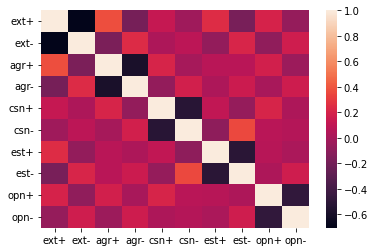

In [23]:
corr_big5 = big5.corr()
sns.heatmap(corr_big5)

In [24]:
corr_big5

,ext+,ext-,agr+,agr-,csn+,csn-,est+,est-,opn+,opn-
ext+,1.000000,-0.706052,0.369949,-0.191410,0.124056,-0.027766,0.246648,-0.183745,0.193790,-0.068421
ext-,-0.706052,1.000000,-0.171263,0.235636,0.021019,0.085876,-0.077607,0.210719,-0.088894,0.165694
agr+,0.369949,-0.171263,1.000000,-0.590661,0.200381,-0.001802,0.068502,0.067572,0.174840,-0.044694
agr-,-0.191410,0.235636,-0.590661,1.000000,-0.076229,0.174161,0.024026,0.147156,0.004463,0.158849
csn+,0.124056,0.021019,0.200381,-0.076229,1.000000,-0.520165,0.104737,-0.072913,0.203444,0.025407
csn-,-0.027766,0.085876,-0.001802,0.174161,-0.520165,1.000000,-0.098805,0.348271,0.070226,0.051624
est+,0.246648,-0.077607,0.068502,0.024026,0.104737,-0.098805,1.000000,-0.513912,0.060941,0.014807
est-,-0.183745,0.210719,0.067572,0.147156,-0.072913,0.348271,-0.513912,1.000000,0.021069,0.164244
opn+,0.193790,-0.088894,0.174840,0.004463,0.203444,0.070226,0.060941,0.021069,1.000000,-0.483382
opn-,-0.068421,0.165694,-0.044694,0.158849,0.025407,0.051624,0.014807,0.164244,-0.483382,1.000000


In [24]:
data_country = data.groupby(['country']).mean()

In [25]:
data_country

,introelapse,testelapse,endelapse,year,month,date,hour,screen_res_class,ext+,ext-,...,csn+_E,csn-_E,est+,est-,est+_E,est-_E,opn+,opn-,opn+_E,opn-_E
country,,,,,,,,,,,,,,,,,,,,,
AD,12484.733333,344.266667,18.866667,2016.933333,7.733333,13.466667,10.800000,8.711177e+05,2.973333,3.133333,...,8369.986667,13622.346667,1.240000,4.733333,2908.893333,7592.626667,5.266667,1.200000,7135.946667,3859.293333
AE,2137.882297,2968.778947,1401.443062,2017.111005,6.226316,15.111962,9.426316,9.752430e+05,3.033206,3.078182,...,8838.384306,7271.231483,1.167368,5.096459,3568.938852,8581.756364,5.174067,1.261435,11088.935885,5874.915598
AF,116.173913,32327.891304,27.978261,2016.782609,6.304348,14.413043,12.695652,9.828737e+05,3.226087,3.082609,...,6890.939130,7607.243478,1.269565,4.647826,2826.930435,9657.460870,5.126087,1.469565,6904.391304,5857.182609
AG,256.227273,366.272727,101.590909,2017.272727,5.909091,15.545455,11.681818,8.154374e+05,2.690909,3.200000,...,5449.072727,3902.681818,1.136364,4.754545,1864.190909,9669.900000,5.500000,1.045455,7856.090909,3299.054545
AI,12.000000,227.500000,17.500000,2017.250000,5.750000,21.000000,7.500000,1.048832e+06,2.950000,3.400000,...,3648.000000,2465.550000,1.250000,4.900000,1235.450000,5081.500000,5.900000,1.000000,4224.550000,2164.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XK,15.000000,344.428571,12.857143,2017.714286,6.714286,16.285714,12.857143,7.442657e+05,2.485714,2.828571,...,7018.542857,6318.857143,1.057143,4.657143,3396.600000,7225.885714,5.057143,1.114286,6755.657143,14569.514286
YE,441.714286,477.642857,38.214286,2017.000000,5.142857,15.928571,8.428571,7.449202e+05,3.185714,3.028571,...,8688.328571,8605.328571,1.085714,5.271429,6327.157143,12196.328571,5.285714,1.357143,8984.642857,5505.900000
ZA,1352.720495,632.309894,42.925442,2017.063958,6.313781,15.414841,8.458657,9.714869e+05,2.880212,3.113922,...,9362.569965,6532.835336,1.161908,4.917032,5786.880848,8484.961979,5.517385,1.130177,7649.935760,9285.923110


<AxesSubplot:xlabel='ext+', ylabel='ext+_E'>

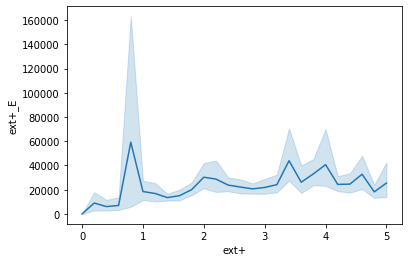

In [26]:
sns.lineplot(x=data['ext+'], y=data['ext+_E'])

<AxesSubplot:xlabel='agr+', ylabel='agr+_E'>

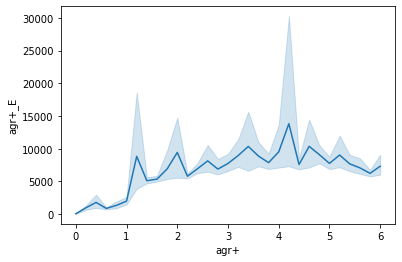

In [27]:
sns.lineplot(x=data['agr+'], y=data['agr+_E'])

<AxesSubplot:xlabel='est+', ylabel='est+_E'>

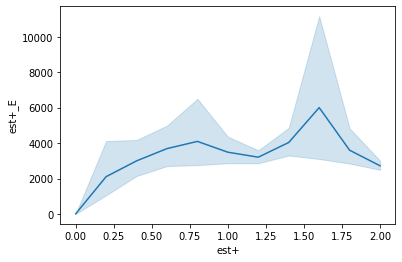

In [28]:
sns.lineplot(x=data['est+'], y=data['est+_E'])

<AxesSubplot:xlabel='csn+', ylabel='csn+_E'>

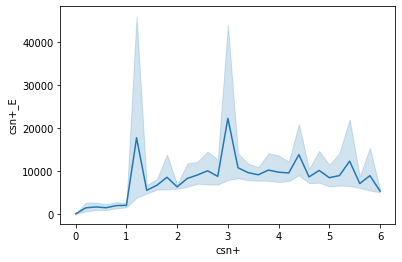

In [29]:
sns.lineplot(x=data['csn+'], y=data['csn+_E'])

<AxesSubplot:xlabel='opn+', ylabel='opn+_E'>

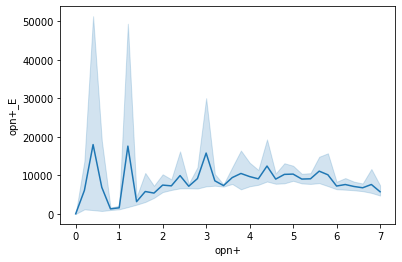

In [30]:
sns.lineplot(x=data['opn+'], y=data['opn+_E'])

## Big five data in US

In [31]:
data_us = data[data.country == 'US']

In [32]:
big_five_us = data_us[['ext+','ext-','agr+','agr-','csn+','csn-','est+','est-','opn+','opn-']]

In [33]:
big_five_us

,ext+,ext-,agr+,agr-,csn+,csn-,est+,est-,opn+,opn-
6,4.0,3.0,5.0,1.6,3.8,2.0,1.2,4.8,6.2,1.2
21,3.0,3.2,4.2,1.8,3.0,2.0,1.4,5.8,3.2,2.2
51,2.0,3.8,3.8,2.8,3.6,1.4,0.6,5.0,5.4,1.4
71,2.4,3.8,2.2,3.6,4.0,3.0,1.2,5.4,4.6,2.0
100,3.8,2.6,5.2,0.8,5.2,1.8,1.4,4.2,5.4,1.2
...,...,...,...,...,...,...,...,...,...,...
1015331,4.0,3.0,5.4,1.6,4.2,1.4,1.8,3.0,6.0,1.0
1015332,3.8,2.2,5.4,1.2,3.8,1.0,1.0,4.8,5.0,1.2
1015337,3.6,3.2,4.8,1.8,3.2,2.4,0.8,7.2,6.0,0.6
1015339,2.0,3.6,4.4,1.8,4.4,1.6,1.0,5.6,5.8,1.2


In [34]:
big_five_us.describe()

,ext+,ext-,agr+,agr-,csn+,csn-,est+,est-,opn+,opn-
count,345167.000000,345167.000000,345167.000000,345167.000000,345167.000000,345167.000000,345167.000000,345167.000000,345167.000000,345167.000000
mean,2.962631,3.080220,4.572518,1.726375,4.137154,2.144050,1.150401,4.821034,5.428008,1.163342
std,1.018074,0.969916,0.949726,0.679988,0.915285,0.785104,0.401580,1.487790,0.930538,0.489926
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.200000,2.400000,4.000000,1.200000,3.600000,1.600000,0.800000,3.800000,4.800000,0.800000
50%,3.000000,3.200000,4.800000,1.600000,4.200000,2.200000,1.200000,4.800000,5.400000,1.000000
75%,3.800000,3.800000,5.200000,2.200000,4.800000,2.800000,1.400000,6.000000,6.200000,1.400000
max,5.000000,5.000000,6.000000,4.000000,6.000000,4.000000,2.000000,8.000000,7.000000,3.000000


In [35]:
big_five_us.corr()

,ext+,ext-,agr+,agr-,csn+,csn-,est+,est-,opn+,opn-
ext+,1.000000,-0.740326,0.355807,-0.203153,0.101109,-0.042549,0.250148,-0.197547,0.169366,-0.073313
ext-,-0.740326,1.000000,-0.197402,0.234509,0.015029,0.075156,-0.095366,0.195052,-0.095092,0.148815
agr+,0.355807,-0.197402,1.000000,-0.633027,0.177186,-0.020925,0.058833,0.039712,0.155513,-0.064570
agr-,-0.203153,0.234509,-0.633027,1.000000,-0.086380,0.163223,0.000577,0.135961,-0.004352,0.147273
csn+,0.101109,0.015029,0.177186,-0.086380,1.000000,-0.564530,0.105839,-0.087199,0.161632,0.033547
csn-,-0.042549,0.075156,-0.020925,0.163223,-0.564530,1.000000,-0.140262,0.343593,0.062283,0.029912
est+,0.250148,-0.095366,0.058833,0.000577,0.105839,-0.140262,1.000000,-0.569810,0.041221,0.006793
est-,-0.197547,0.195052,0.039712,0.135961,-0.087199,0.343593,-0.569810,1.000000,-0.001755,0.153122
opn+,0.169366,-0.095092,0.155513,-0.004352,0.161632,0.062283,0.041221,-0.001755,1.000000,-0.512560
opn-,-0.073313,0.148815,-0.064570,0.147273,0.033547,0.029912,0.006793,0.153122,-0.512560,1.000000


In [36]:
big5.corr()

,ext+,ext-,agr+,agr-,csn+,csn-,est+,est-,opn+,opn-
ext+,1.000000,-0.706052,0.369949,-0.191410,0.124056,-0.027766,0.246648,-0.183745,0.193790,-0.068421
ext-,-0.706052,1.000000,-0.171263,0.235636,0.021019,0.085876,-0.077607,0.210719,-0.088894,0.165694
agr+,0.369949,-0.171263,1.000000,-0.590661,0.200381,-0.001802,0.068502,0.067572,0.174840,-0.044694
agr-,-0.191410,0.235636,-0.590661,1.000000,-0.076229,0.174161,0.024026,0.147156,0.004463,0.158849
csn+,0.124056,0.021019,0.200381,-0.076229,1.000000,-0.520165,0.104737,-0.072913,0.203444,0.025407
csn-,-0.027766,0.085876,-0.001802,0.174161,-0.520165,1.000000,-0.098805,0.348271,0.070226,0.051624
est+,0.246648,-0.077607,0.068502,0.024026,0.104737,-0.098805,1.000000,-0.513912,0.060941,0.014807
est-,-0.183745,0.210719,0.067572,0.147156,-0.072913,0.348271,-0.513912,1.000000,0.021069,0.164244
opn+,0.193790,-0.088894,0.174840,0.004463,0.203444,0.070226,0.060941,0.021069,1.000000,-0.483382
opn-,-0.068421,0.165694,-0.044694,0.158849,0.025407,0.051624,0.014807,0.164244,-0.483382,1.000000
